In [6]:
import sys
sys.path.append("../classes")

In [7]:
import pickle
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.manifold import TSNE, Isomap, MDS, SpectralEmbedding
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import numpy as np, pandas as pd
from geno_classifier import *
from itertools import starmap, product

import GEOparse

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

### Clustering on diff values

In [8]:
change_lable = lambda label, prefix: '{}_{}'.format(prefix, label)

### breast-cancer

In [11]:
bc_results = pickle.load(open('../results/breast_cancer3.results','rb'))
bc_labels_ = pickle.load(open('../datasets/breast_cancer3_y','rb'))

breast_cancer, breast_cancer_labels = preprocess_results(bc_results, bc_labels_, 
                                                         use_diff_score=True, use_pathways=True, 
                                                         scale=False, use_one_hot=False)

breast_cancer.index = starmap(change_lable, product(bc_labels_, ['bc']))

In [12]:
len(list(starmap(change_lable, product(bc_labels_, 'bc'))))

1194

In [13]:
breast_cancer[breast_cancer.columns[:5]].head()

,,Alanine and aspartate metabolism,Alkaloid synthesis,Aminosugar metabolism,Androgen and estrogen synthesis and metabolism
bc_unhealthy,-105.359273,-11.602715,-140.623088,-189.171402,-140.623089
bc_unhealthy,-124.191283,-117.663321,-140.623088,-232.182155,-140.623089
bc_unhealthy,-183.420031,-242.663316,-140.623083,-156.913332,-140.623081
bc_unhealthy,-53.638618,-152.197219,-140.623088,-210.676778,-140.623089
bc_unhealthy,-184.590950,-242.663272,-140.623039,-232.182113,-140.623040


### lung-cancer

In [14]:
lc_results = pickle.load(open('../results/lung_cancer_1.results','rb'))
lc_labels_ = pickle.load(open('../datasets/lung_cancer_1_y','rb'))

lung_cancer, lung_cancer_y = preprocess_results(lc_results, lc_labels_, 
                                                use_diff_score=True, use_pathways=True, 
                                                scale=False, use_one_hot=False)

lung_cancer.index = starmap(change_lable, product(lc_labels_, ['lg']))

In [15]:
lung_cancer[lung_cancer.columns[:5]].head()

,,Alanine and aspartate metabolism,Alkaloid synthesis,Aminosugar metabolism,Androgen and estrogen synthesis and metabolism
lg_unhealthy,48.843000,138.648466,-0.000006,-82.204632,-0.000011
lg_unhealthy,2.642386,138.648466,-0.000006,-82.204632,-0.000011
lg_unhealthy,41.381614,-4.367172,-0.000006,-82.204632,-0.000011
lg_unhealthy,-3.062908,109.866720,-0.000005,-114.462695,-0.000009
lg_unhealthy,89.662783,138.648466,-0.000006,-103.710008,-0.000011


In [16]:
cc_results = pickle.load(open('../results/colon_cancer.results','rb'))
cc_labels_ = pickle.load(open('../datasets/colon_cancer_Xy','rb'))["y"]

colon_cancer, colon_cancer_y = preprocess_results(cc_results, cc_labels_, 
                                                use_diff_score=True, use_pathways=True, 
                                                scale=False, use_one_hot=False)

colon_cancer.index = starmap(change_lable, product(cc_labels_, ['cc']))

In [17]:
colon_cancer[colon_cancer.columns[:5]].head()

,,Alanine and aspartate metabolism,Alkaloid synthesis,Aminosugar metabolism,Androgen and estrogen synthesis and metabolism
cc_healthy,-56.854475,81.990621,-0.000003,-20.717564,-0.000003
cc_healthy,24.866507,-51.435305,-0.000003,-20.717564,-0.000003
cc_unhealthy,-51.641041,-51.765993,-0.000003,145.949103,-0.000002
cc_healthy,-22.276013,-36.606562,0.000001,-20.717560,0.000001
cc_unhealthy,-11.444609,-113.935285,0.000025,-20.717542,0.000027


### diseases combined

In [18]:
classes = {'bc_unhealthy': 0, 'bc_healthy': 1, 'lg_unhealthy': 2, 'lg_healthy': 3, 'cc_healthy':4, 'cc_unhealthy':5}

In [19]:
diseases = pd.concat([breast_cancer, lung_cancer, colon_cancer])
reduced_diseases = PCA(n_components=2).fit_transform(diseases)

y = [classes[i] for i in np.array(diseases.index)]

In [20]:
kmeans = KMeans(n_clusters=5, random_state=42).fit(reduced_diseases)

### healthy grey, bc magenta, lg pink

In [21]:
colors = {0 : 'darkmagenta', 1 : 'lightpink', 2 : 'grey', 3:'lightblue', 4:'green', 5:'red'}

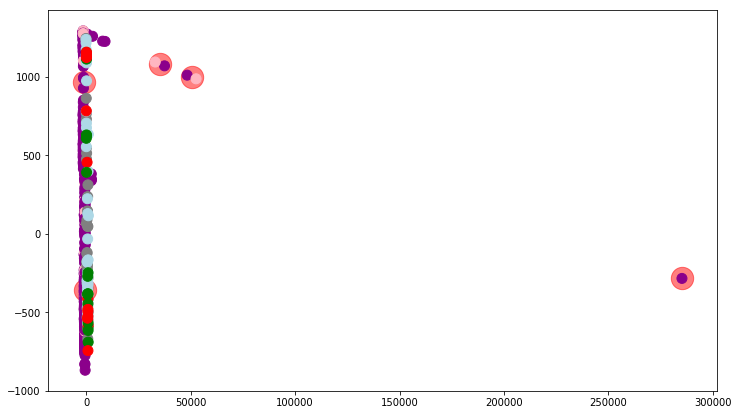

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))

centers = kmeans.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='red', alpha=0.5, s=500)
plt.scatter(reduced_diseases[:, 0], reduced_diseases[:, 1], c=[colors[i] for i in y], s=100)

In [23]:
from sklearn.metrics import homogeneity_completeness_v_measure

In [24]:
homogeneity_completeness_v_measure(y, kmeans.labels_)

(0.017337573012290174, 0.02757850674792654, 0.021290565733460023)

## t-SNE

In [25]:
diseases_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(diseases)

In [26]:
kmeans_tsne = KMeans(n_clusters=5, random_state=42).fit(diseases_reduced_tsne)

In [27]:
homogeneity_completeness_v_measure(y, kmeans_tsne.labels_)

(0.4418832270247428, 0.2857667998789591, 0.3470777187884576)

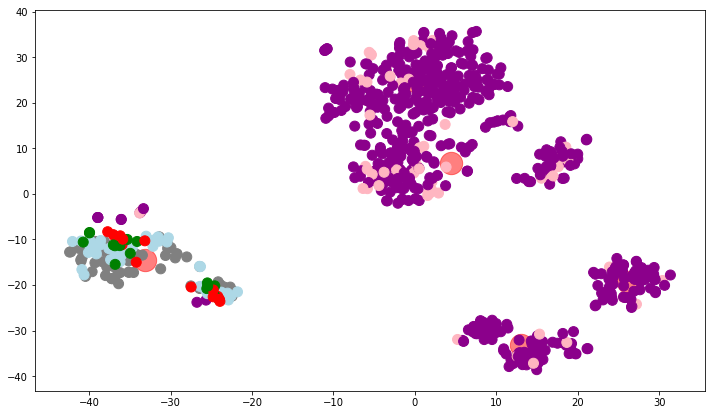

In [28]:
plt.figure(figsize=(12, 7))

centers = kmeans_tsne.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='red', alpha=0.5, s=500)
plt.scatter(diseases_reduced_tsne[:, 0], diseases_reduced_tsne[:, 1], c=[colors[i] for i in y], s=100)

## LDA

In [29]:
diseases_reduced_lda = LinearDiscriminantAnalysis(n_components=2).fit_transform(diseases, y)

/home/abdu/Desktop/virtualenv/GERA/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:442 UserWarning: The priors do not sum to 1. Renormalizing
/home/abdu/Desktop/virtualenv/GERA/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388 UserWarning: Variables are collinear.


In [30]:
kmeans_lda = KMeans(n_clusters=5, random_state=42).fit(diseases_reduced_lda)

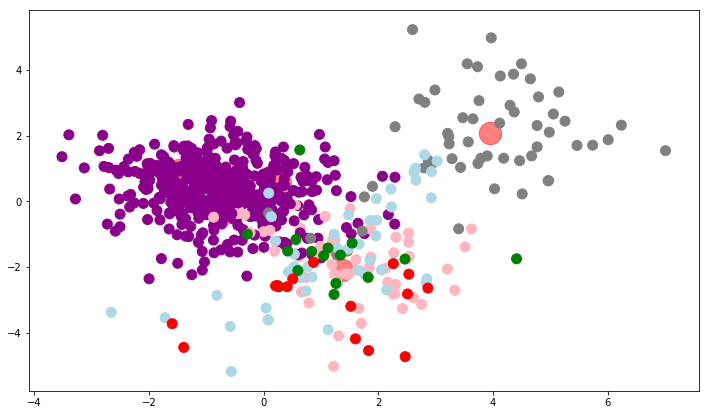

In [31]:
plt.figure(figsize=(12, 7))

centers = kmeans_lda.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='red', alpha=0.5, s=500)
plt.scatter(diseases_reduced_lda[:, 0], diseases_reduced_lda[:, 1], c=[colors[i] for i in y], s=100)

## K-best

In [32]:
diseases_reduced_kbest = SelectKBest(k=2).fit_transform(diseases, y)

In [33]:
kmeans_kbest = KMeans(n_clusters=5, random_state=42).fit(diseases)

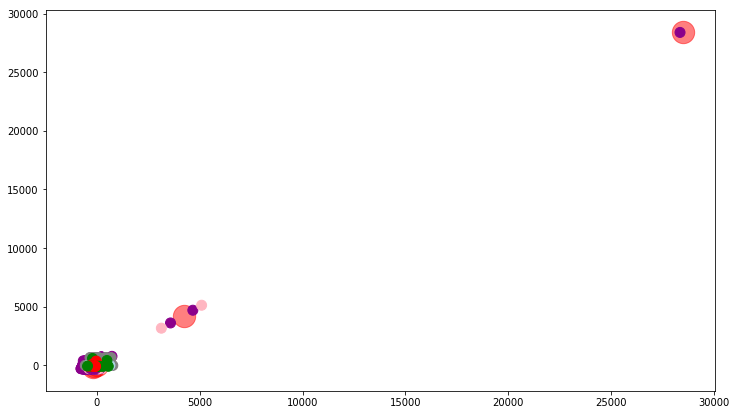

In [34]:
plt.figure(figsize=(12, 7))

centers = kmeans_kbest.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='red', alpha=0.5, s=500)
plt.scatter(diseases_reduced_kbest[:, 0], diseases_reduced_kbest[:, 1], c=[colors[i] for i in y], s=100)

## Hierarchical clustering

In [35]:
from scipy.cluster import hierarchy

In [36]:
labels_ = list(diseases.iterrows())
labels = dict()
for i in range(len(labels_)):
    labels[i] = labels_[i][0]
labels = np.array(list(labels.items()))

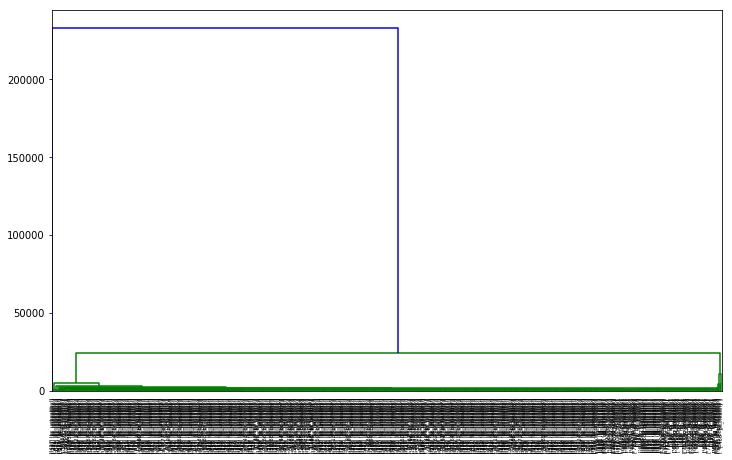

In [37]:
Z = hierarchy.linkage(diseases, method='single')
plt.figure(figsize=(12, 7))
dn = hierarchy.dendrogram(Z, labels=labels)
plt.savefig("hclustering-diff")

# Using no Pathways or Diff Values

In [38]:
breast_cancer, breast_cancer_labels = preprocess_results(bc_results, bc_labels_, 
                                                         use_diff_score=False, use_pathways=False, 
                                                         scale=False, use_one_hot=False)

breast_cancer.index = starmap(change_lable, product(bc_labels_, ['bc']))

lung_cancer, lung_cancer_y = preprocess_results(lc_results, lc_labels_, 
                                                use_diff_score=False, use_pathways=False, 
                                                scale=False, use_one_hot=False)

lung_cancer.index = starmap(change_lable, product(lc_labels_, ['lg']))

cc_results = pickle.load(open('../results/colon_cancer.results','rb'))
cc_labels_ = pickle.load(open('../datasets/colon_cancer_Xy','rb'))["y"]

colon_cancer, colon_cancer_y = preprocess_results(cc_results, cc_labels_, 
                                                use_diff_score=False, use_pathways=False, 
                                                scale=False, use_one_hot=False)

colon_cancer.index = starmap(change_lable, product(cc_labels_, ['cc']))

## PCA

In [39]:
diseases = pd.concat([breast_cancer, lung_cancer, colon_cancer])
reduced_diseases = PCA(n_components=2).fit_transform(diseases)

y = [classes[i] for i in np.array(diseases.index)]
kmeans = KMeans(n_clusters=5, random_state=42).fit(reduced_diseases)
homogeneity_completeness_v_measure(y, kmeans.labels_)

(0.18399678357171342, 0.18014025181265356, 0.18204809565904295)

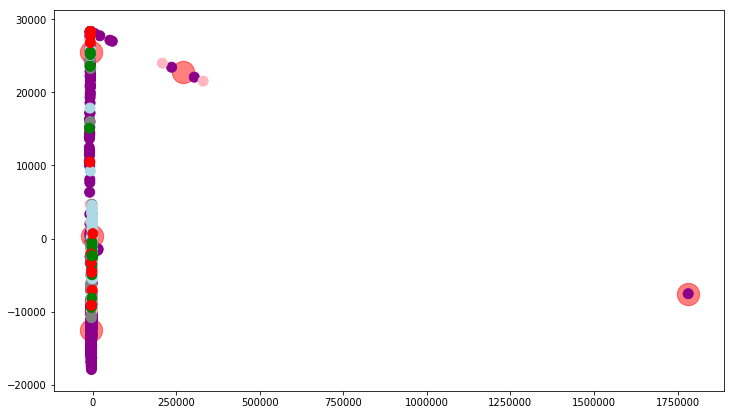

In [40]:
plt.figure(figsize=(12, 7))

centers = kmeans.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='red', alpha=0.5, s=500)
plt.scatter(reduced_diseases[:, 0], reduced_diseases[:, 1], c=[colors[i] for i in y], s=100)

## t-SNE

In [41]:
diseases_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(diseases)
kmeans_tsne = KMeans(n_clusters=5, random_state=42).fit(diseases_reduced_tsne)
homogeneity_completeness_v_measure(y, kmeans_tsne.labels_)

(0.15109431236640142, 0.09448148688264514, 0.11626239503682582)

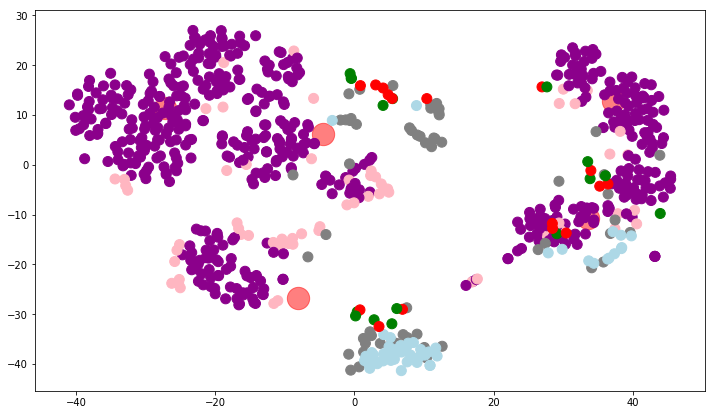

In [42]:
plt.figure(figsize=(12, 7))

centers = kmeans_tsne.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='red', alpha=0.5, s=500)
plt.scatter(diseases_reduced_tsne[:, 0], diseases_reduced_tsne[:, 1], c=[colors[i] for i in y], s=100)

## H-Clustering

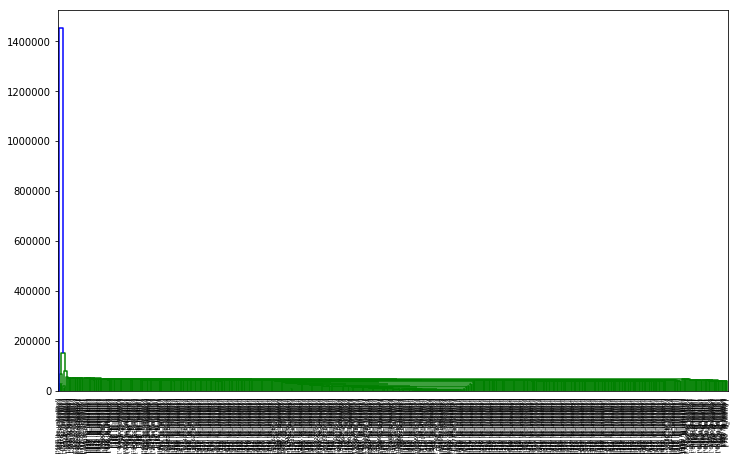

In [43]:
Z = hierarchy.linkage(diseases, method='single')
plt.figure(figsize=(12, 7))
dn = hierarchy.dendrogram(Z, labels=labels)
plt.savefig("hclustering-nodiff")